# Traveling Salesman Problem
The Traveling Salesman Problem (TSP) concerns finding the shortest path that a traveling salesman can take to go through a list of cities in the shortest time possible. This problem is represented in a graph $G =(V,E)$. Each vertex in the graph $G$ represents a different camp, while the weights on each of the edges $(u,v)$ represent the distance between the two camps $u$ and $v$. 

This is an NP-Hard problem, and there is no known classical algorithm that is know to solve this problem in linear time. 


# Real Life Challenges 

In this challenge, you will be tasked with solving TSP for an extended graph on a quantum computer that has a limited number of qubits. Specifically, the quantum computer will only have 6 qubits available. Moreover, the extended graph includes two new nodes a starting and ending locations. Your solution must begin at the starting point which is Karanga Camp and end at the Kibo peak.

To solve this challenge, you will need to accomplish the following tasks:

1. Design and build a new Hamiltonian that takes into account the lack of qubits and the addition of the two new nodes.
2. Calculate and analyze the fidelity of both the AQO and QAOA solutions.
3. Experiment with different scheduling strategies to improve the fidelity of your solution.

It is important that you document the steps you follow and your findings in a clear and concise manner. Good luck!

## Graph construction 

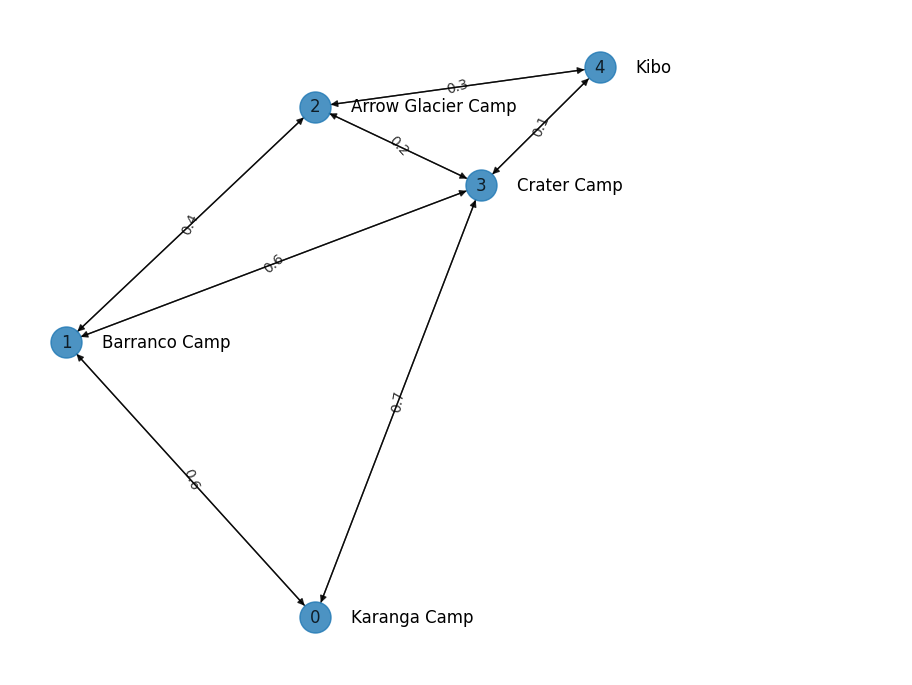

In [1]:
import matplotlib.pylab as plt
import networkx as nx
import numpy as np 

# define a directed graph 
G = nx.DiGraph()

# define the edges of the graph with their corresponding weights
G.add_edge(0, 1, weight=0.6)
G.add_edge(1, 0, weight=0.6)

G.add_edge(0, 3, weight=0.7)
G.add_edge(3, 0, weight=0.7)

G.add_edge(1, 3, weight=0.6)
G.add_edge(3, 1, weight=0.6)

G.add_edge(1, 2, weight=0.4)
G.add_edge(2, 1, weight=0.4)

G.add_edge(2, 3, weight=0.2)
G.add_edge(3, 2, weight=0.2)

G.add_edge(3, 4, weight=0.1)
G.add_edge(4, 3, weight=0.1)

G.add_edge(2, 4, weight=0.3)
G.add_edge(4, 2, weight=0.3)


# save the labels of the various edges to be able to plot them.
edge_labels= {}
for (u,v) in G.edges():
    edge_labels[(u,v)] = G[u][v]["weight"]

pos = {0: np.array([0.01, -1 ]), 1: np.array([-0.2, -0.3 ]), 2: np.array([0.01 ,  0.3]), 3: np.array([0.15, 0.1 ]), 4: np.array([0.25, 0.4 ])}

# creating node labels
labels = {}
labels[0] = 'Karanga Camp'
labels[1] = 'Barranco Camp'
labels[2] = 'Arrow Glacier Camp'
labels[3] = 'Crater Camp'
labels[4] = 'Kibo'

# applying a shift to the node labels for readability purposes 
shift = np.array([0.03, 0])
shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

# draw node labels
nx.draw_networkx_labels(G, shifted_pos, labels=labels, horizontalalignment="left")


#plot the graph and the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, alpha=0.8)
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500)

# adjust frame to avoid cutting text, may need to adjust the value
axis = plt.gca()
lim = axis.get_xlim()
axis.set_xlim([lim[0], lim[1] * 1.7])

# increase the size of the figure
figure_size = plt.gcf().get_size_inches()
factor = 1.8
plt.gcf().set_size_inches(factor * figure_size)

plt.show()


## Solution 
The idea under this implementation is to leverage the fact that the starting and the final point are alreay fixed.
The information can hint us that only 3 edges are really required to represent all the Travelling Salesman Path.
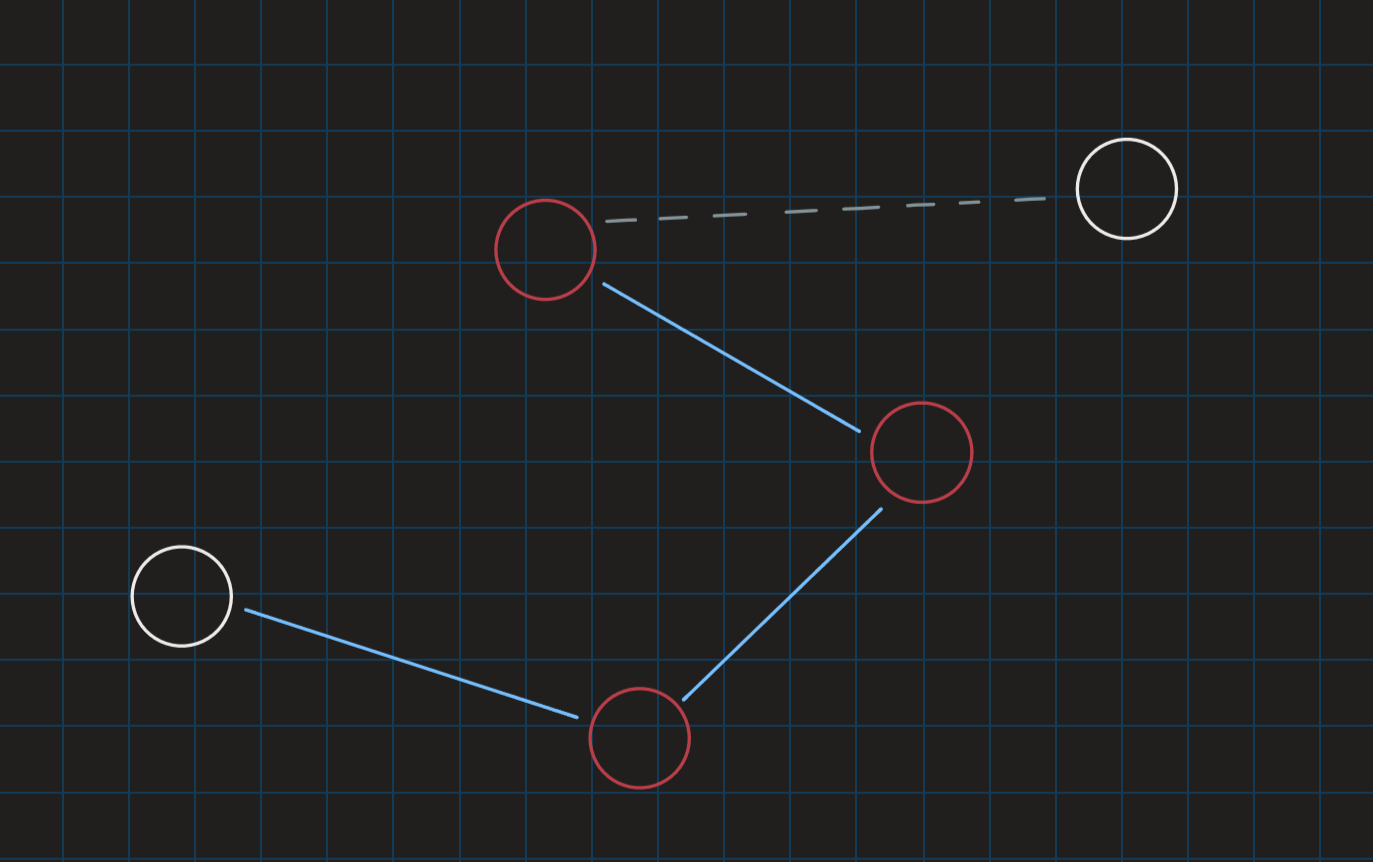

From that we tried to encode the information into a 6-qbit representation. The main important thing to consider in chosing a rapresentation was its ability to be handled by a simple enough cost function.

We tried several approaches, like encoding the graph edge number in a 2bit rapresentation for each of the 3 central nodes.
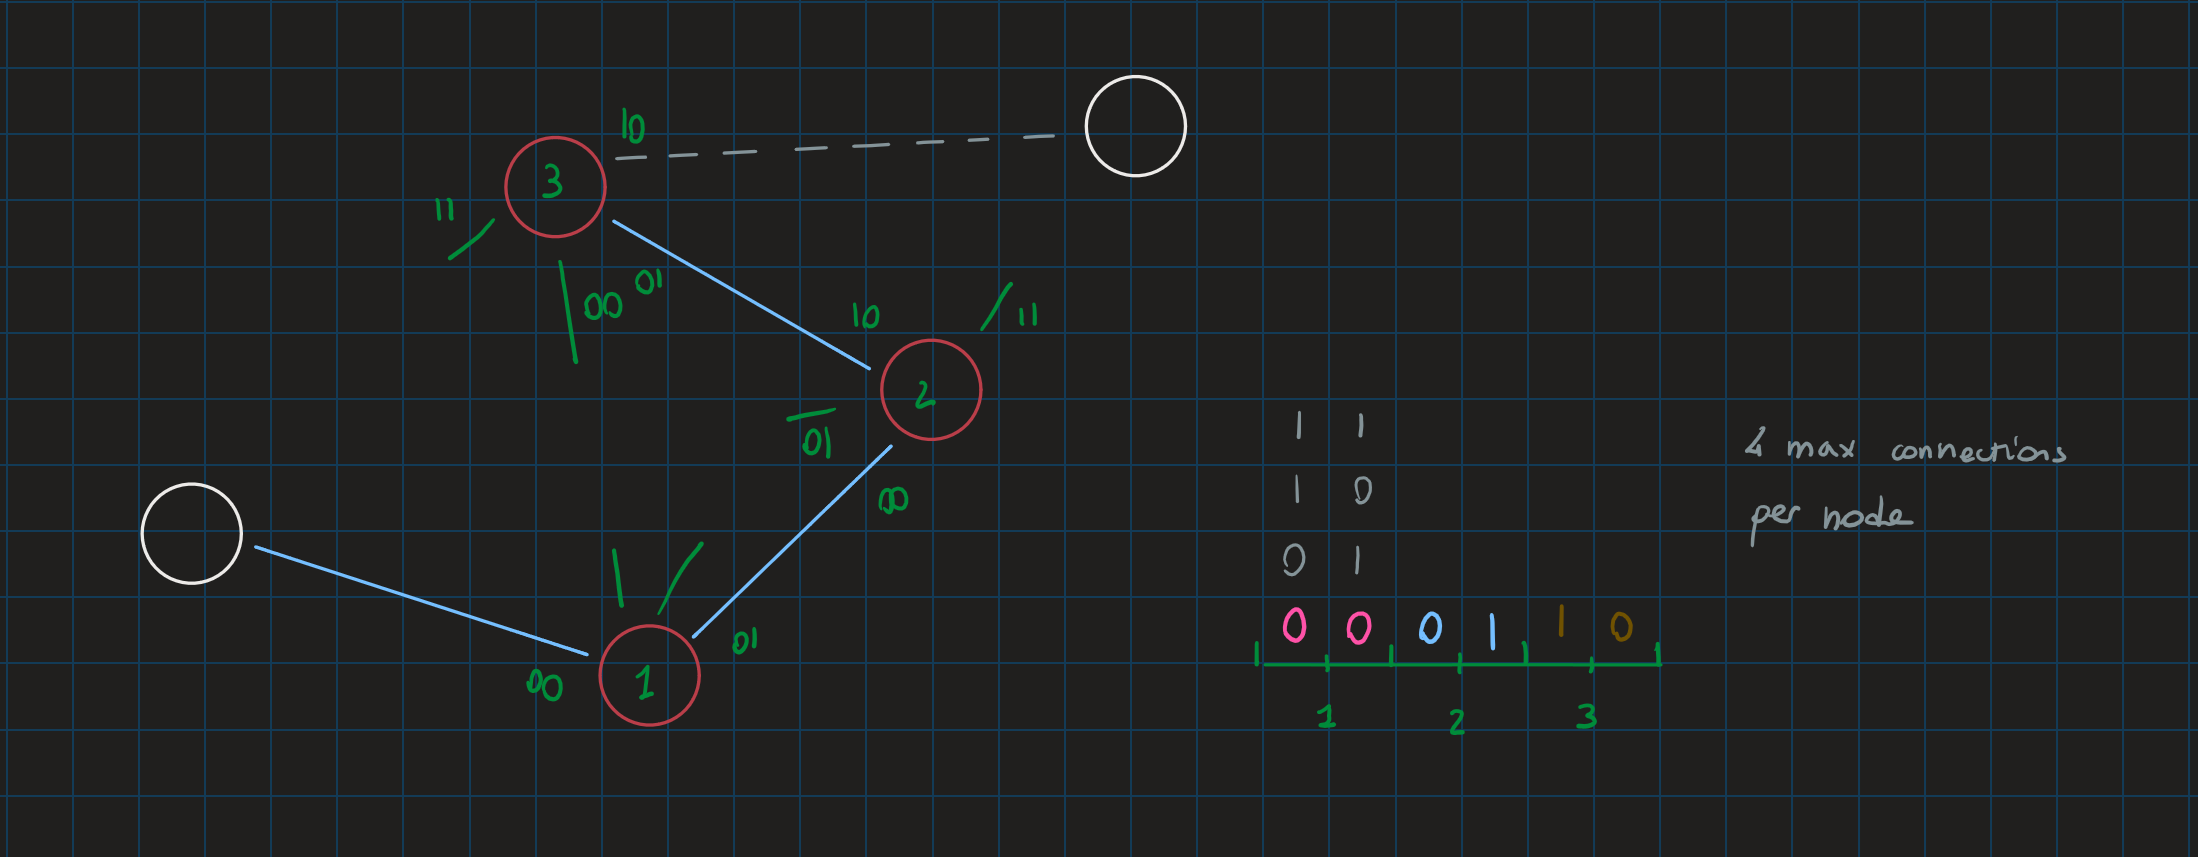

Or maybe just fall back to our initial 3-nodes problem and then only the other remaining 2 qbits to encode the state connected to the final one (again, the connection between the inital point and the second should be implicit)
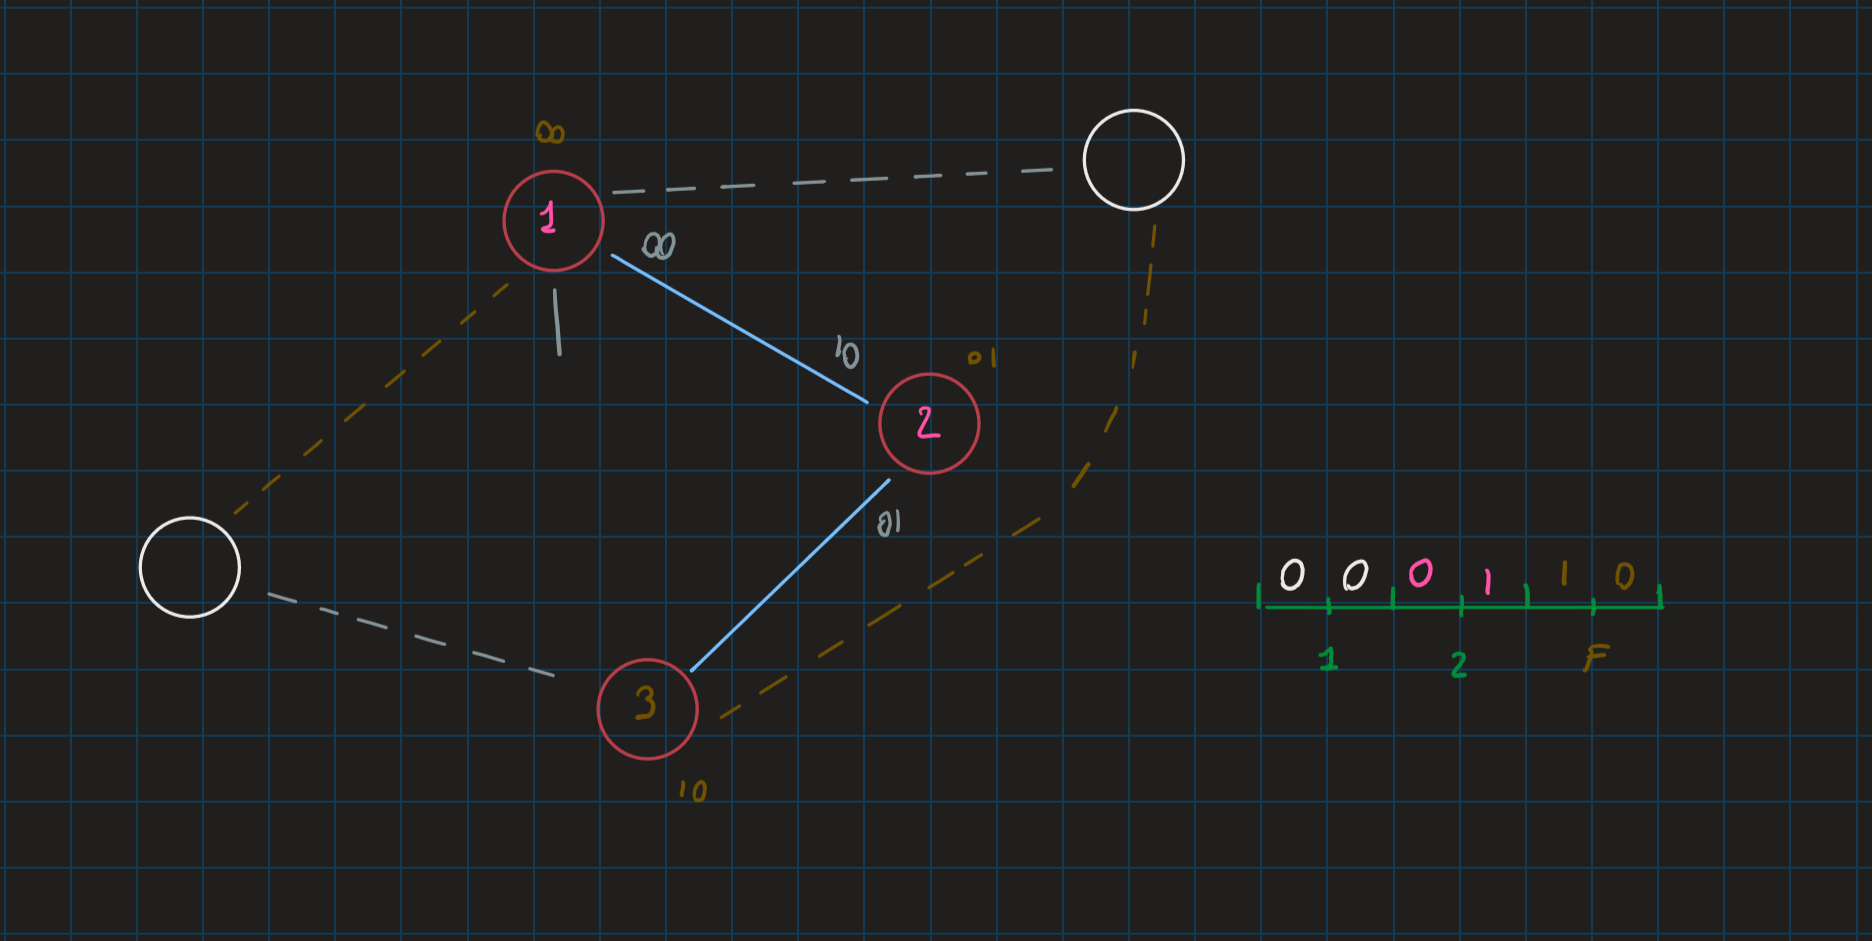

In [108]:
from qibo.symbols import Z, X, Y
from qibo import hamiltonians

def build_TSP_hamiltonian(G : nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    P = 20
    X = 100
    center_cost = [0.6 + 0.6, 0.4 + 0.2, 0.6 + 0.2]
    dx_cost = [X, 0.3, 0.1]
    sx_cost = [0.6, X, 0.7]
    
    sham = 0
    shampa = 0
    shampb = 0
    shampe = 0
    
    for i in range(3):
        sham += (center_cost[i]) * (1 - Z(i)) / 2
    for i in range(3, 6):
        sham += (dx_cost[i-3]) * (1 - Z(i)) / 2
    for i in range(3):
        sham += sx_cost[i] * ( 1/2 + 1/2 * ( 3 / 4 - (( Z(i) + Z(i+3) + Z(i) * Z(i+3) ) / 4) )) # OR
        # sham += sx_cost[i] * ( 1/2 + 1/2 * (1/2 - 1/2 * Z(i) * Z(i+3))) # XOR
    
    # Penalizing center invality
    for j in range(3):
        shampa += (1 - Z(j)) / 2
    shampa =  P * (1 - shampa) * (1 - shampa)

    for j in range(3, 6):
        shampb += (1 - Z(j)) / 2
    shampb =  P * (1 - shampb) * (1 - shampb)
    
    for j in range(3):
        shampe += (1 - Z(j) - Z(j+3) + Z(j)*Z(j+3)) / 4
    shampe = P * shampe
    
    sham = sham + shampa + shampb + shampe

    return hamiltonians.SymbolicHamiltonian(sham)


def build_mixer_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    
    sham = sum((X(i)) for i in range(6))
    
    return hamiltonians.SymbolicHamiltonian(sham)

def build_initial_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    
    pass

def prepare_initial_state(G: nx.Graph):
    
    return np.ones(64) 

def display_solution(state: str):
    
    print(state)

## Hamiltonian Calculation

In [109]:
hamiltonian = build_TSP_hamiltonian(G)

dense = hamiltonian.dense.matrix

print(dense)
print(np.diagonal(dense))
print(np.argmin(np.diagonal(dense))) 

len(dense)

[Qibo 0.1.13|WARNING|2023-05-07 05:20:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


[ 90.65+0.j  71.1 +0.j 120.95+0.j 141.4 +0.j 170.95+0.j 191.4 +0.j
 241.25+0.j 301.7 +0.j  71.8 +0.j  71.9 +0.j 102.1 +0.j 142.2 +0.j
 152.1 +0.j 192.2 +0.j 222.4 +0.j 302.5 +0.j 121.25+0.j 101.7 +0.j
 121.55+0.j 142.  +0.j 201.55+0.j 222.  +0.j 241.85+0.j 302.3 +0.j
 142.4 +0.j 142.5 +0.j 142.7 +0.j 182.8 +0.j 222.7 +0.j 262.8 +0.j
 263.  +0.j 343.1 +0.j  72.15+0.j  52.6 +0.j 102.45+0.j 122.9 +0.j
 172.15+0.j 192.6 +0.j 242.45+0.j 302.9 +0.j  93.3 +0.j  93.4 +0.j
 123.6 +0.j 163.7 +0.j 193.3 +0.j 233.4 +0.j 263.6 +0.j 343.7 +0.j
 142.75+0.j 123.2 +0.j 143.05+0.j 163.5 +0.j 242.75+0.j 263.2 +0.j
 283.05+0.j 343.5 +0.j 203.9 +0.j 204.  +0.j 204.2 +0.j 244.3 +0.j
 303.9 +0.j 344.  +0.j 344.2 +0.j 424.3 +0.j]
33


64

In [110]:
import numpy as np
from qibo import models, hamiltonians


nqubits = 6
print("number of qubits needed to solve the problem: ", nqubits)

# create the cost Hamiltonian for the given graph
hamiltonian = build_TSP_hamiltonian(G)

# create the mixer Hamiltonian for the given graph
mixer_hamiltonian = build_mixer_hamiltonian(G)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with eight layers 
# Note: you can change the number of layers but it has to be an even number
num_layers = 8
initial_parameters = np.random.random(num_layers) 

# prepare the initial state of the QAOA optimization 
initial_state = prepare_initial_state(G) 

# run the QAOA optimization with the initial parameters and the hamiltonians defined
best_energy, final_parameters, extra = qaoa.minimize(
    initial_parameters, 
    method="BFGS",
    initial_state=initial_state
    )

print("best energy: ", best_energy)

number of qubits needed to solve the problem:  6
best energy:  9837.68185663657


In [111]:
from qibo.states import CircuitResult
from qibo import gates
from qibo.models import Circuit

# build the circuit using the optimal parameters optimized by QAOA
qaoa.set_parameters(final_parameters)
quantum_state = qaoa.execute(initial_state)

# measure the output of the circuit and obtain results
nshots= 4000
circuit = Circuit(nqubits)
circuit.add(gates.M(*range(nqubits)))
result = CircuitResult(qaoa.backend, circuit, quantum_state, nshots=nshots)
freq_counter = result.frequencies()

# order the results according to the frequencies
ordered_freq_counter = sorted(freq_counter.items(), key=lambda item: item[1], reverse=True)
qaoa_solution = ordered_freq_counter[0][0]

display_solution(qaoa_solution) # QAOA solution is a binary string containing the solution 

100001
